In [1]:
import argparse

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from ImageDataset import *
from unet import *
from loss import *

## Unzip The Data  
Only if running on google colab


In [2]:
import zipfile
import os

# Specify the path to the uploaded zip file
zip_path = 'data.zip'
pred_path = '/predictions.zip'

# Specify the directory where you want to extract the contents

# Create the extraction directory if it doesn't exist

#Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()
#with zipfile.ZipFile(pred_path, 'r') as zip_ref:
    #zip_ref.extractall()


In [3]:
TRAIN_IMAGES = 'data/training/images/'
GROUNDTRUTH = 'data/training/groundtruth/'
TEST_IMAGES = 'data/test_set_images/'
TRAIN_AUG_IMAGES = 'data/augmented/images/'
TRAIN_AUG_IMAGES_GT = 'data/augmented/groundtruth/'
#AUG_IM_DATASET= 'data/augmented/images_for_train_1/'
#AUG_GT_DATASET='data/augmented/groundtruth_for_train_1/'

FOREGROUND_TRESHOLD = 0.25
SPLIT_RATIO = 0.9
BATCH_SIZE = 10
EPOCHS = 30
LR = 1e-3
SEED = 0
WEIGHT_DECAY = 1e-3
WORKERS = 2

In [21]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cuda


In [22]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [23]:
dataset_augmented=ImagesDataset(
    img_dir=TRAIN_AUG_IMAGES,
    gt_dir=TRAIN_AUG_IMAGES_GT,
    image_transform=image_transform,
    mask_transform=mask_transform,
)


In [24]:

len(dataset_augmented)

200

In [25]:
image, mask = dataset_augmented[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)

Image size: torch.Size([3, 400, 400])
Mask size: torch.Size([1, 400, 400])


In [26]:
train_loader_augmented=DataLoader(
    dataset=dataset_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)


In [27]:
model= UNet().to(device)

In [28]:
criterion = DiceLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [29]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=5,
    verbose=True,
)

In [30]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm


# Set the model in training mode
model.train()

# Define the number of training epochs
epochs = 250  # You can adjust this as needed

# List to store epoch and loss pairs
loss_history = []

# Training loop
for epoch in range(epochs):
    total_loss = 0.0

    # Iterate over the training data
    for data, target in tqdm(train_loader_augmented, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        # Send the input to the device
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the total loss
        total_loss += loss.item()

    # Average loss for the epoch
    average_loss = total_loss / len(train_loader_augmented)
    print(f"average loss: ", average_loss)

    # Save epoch and loss to the history list
    loss_history.append((epoch + 1, average_loss))

    # Adjust learning rate if a scheduler is provided
    if lr_scheduler is not None:
        lr_scheduler.step(average_loss)

torch.save(model.state_dict(), 'trained_model_aug.pth')

# Save the trained model
#torch.save(model.state_dict(), 'trained_model.pth')

# Now, you can use the trained model for predictions
# For example, if you have a test DataLoader, you can do:
# model.eval()
# with torch.no_grad():
#     for test_data in test_data_loader:
#         test_data = test_data.to(device)
#         predictions = model(test_data)
#         # Process predictions as needed based on proba_threshold
#         # ...

# Note: This is a basic example, and you might need to adapt it based on your specific requirements and dataset structure.


Epoch 1/250: 100%|██████████| 20/20 [00:11<00:00,  1.67batch/s]


average loss:  0.6825408399105072


Epoch 2/250: 100%|██████████| 20/20 [00:12<00:00,  1.65batch/s]


average loss:  0.6403045862913131


Epoch 3/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.6269537478685379


Epoch 4/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.6099662601947784


Epoch 5/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.601172336935997


Epoch 6/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.595210999250412


Epoch 7/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5947302341461181


Epoch 8/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.58343106508255


Epoch 9/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.5682221293449402


Epoch 10/250: 100%|██████████| 20/20 [00:11<00:00,  1.68batch/s]


average loss:  0.5659255772829056


Epoch 11/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.5700360029935837


Epoch 12/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5548770785331726


Epoch 13/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5630809247493744


Epoch 14/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5501449137926102


Epoch 15/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5386753112077713


Epoch 16/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.55145922601223


Epoch 17/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5345042228698731


Epoch 18/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5407219648361206


Epoch 19/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.5573758751153945


Epoch 20/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.5393385291099548


Epoch 21/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.5362580686807632


Epoch 22/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5336657196283341


Epoch 23/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.5303038746118546


Epoch 24/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5280132263898849


Epoch 25/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.5264190196990967


Epoch 26/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5283196032047272


Epoch 27/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.5145298957824707


Epoch 28/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.5007685035467148


Epoch 29/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5118012517690659


Epoch 30/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5183564305305481


Epoch 31/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5249888092279434


Epoch 32/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5254204511642456


Epoch 33/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5171691238880157


Epoch 34/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.5165277659893036
Epoch 00034: reducing learning rate of group 0 to 1.0000e-04.


Epoch 35/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.4995893746614456


Epoch 36/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.4840827524662018


Epoch 37/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.4772262066602707


Epoch 38/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.47536167204380037


Epoch 39/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.47831974029541013


Epoch 40/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4818552792072296


Epoch 41/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.47207716703414915


Epoch 42/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.46678478121757505


Epoch 43/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.47127915918827057


Epoch 44/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.47042763531208037


Epoch 45/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.46078710854053495


Epoch 46/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.46035149693489075


Epoch 47/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4590612053871155


Epoch 48/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.46464203000068666


Epoch 49/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4542963713407516


Epoch 50/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.45901559591293334


Epoch 51/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4499080240726471


Epoch 52/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4445281356573105


Epoch 53/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.46230873465538025


Epoch 54/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.4458514302968979


Epoch 55/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.44187345504760744


Epoch 56/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4408471643924713


Epoch 57/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4384663701057434


Epoch 58/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.4387289613485336


Epoch 59/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.428625750541687


Epoch 60/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.4329562604427338


Epoch 61/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.4238996356725693


Epoch 62/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4275411456823349


Epoch 63/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.42998580634593964


Epoch 64/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4292623281478882


Epoch 65/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.4177528411149979


Epoch 66/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.42142505943775177


Epoch 67/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.42818332016468047


Epoch 68/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.41450988948345185


Epoch 69/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.41848196983337405


Epoch 70/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.4122380405664444


Epoch 71/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.41549655199050906


Epoch 72/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.4052354484796524


Epoch 73/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.4062447249889374


Epoch 74/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4005347013473511


Epoch 75/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.39594084918498995


Epoch 76/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3946201831102371


Epoch 77/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.40289110839366915


Epoch 78/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.4024866342544556


Epoch 79/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.391271123290062


Epoch 80/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.38950473070144653


Epoch 81/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3949957489967346


Epoch 82/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.38653287291526794


Epoch 83/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.38206843435764315


Epoch 84/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.37696159482002256


Epoch 85/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3767926186323166


Epoch 86/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.38775805830955506


Epoch 87/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3724073231220245


Epoch 88/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.3780866086483002


Epoch 89/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.36630772054195404


Epoch 90/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.36535322964191436


Epoch 91/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.3713690161705017


Epoch 92/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3582246541976929


Epoch 93/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.370895779132843


Epoch 94/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.37385889887809753


Epoch 95/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3578963279724121


Epoch 96/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.36260266304016114


Epoch 97/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3609226793050766


Epoch 98/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.3550823777914047


Epoch 99/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3489282697439194


Epoch 100/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3421428471803665


Epoch 101/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.34685673415660856


Epoch 102/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3322449803352356


Epoch 103/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.33419192135334014


Epoch 104/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.33802151679992676


Epoch 105/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3332008123397827


Epoch 106/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3230774521827698


Epoch 107/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.3304229468107224


Epoch 108/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3272725254297256


Epoch 109/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.32341670989990234


Epoch 110/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3182564347982407


Epoch 111/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3188174366950989


Epoch 112/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3205245077610016


Epoch 113/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.32176350355148314


Epoch 114/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.31969372630119325


Epoch 115/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3084878444671631


Epoch 116/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.3121634066104889


Epoch 117/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.30686338543891906


Epoch 118/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.30584120452404023


Epoch 119/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.3034605741500854


Epoch 120/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.29557674527168276


Epoch 121/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.29656738340854644


Epoch 122/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.28341129422187805


Epoch 123/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.2823697835206985


Epoch 124/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.29227620363235474


Epoch 125/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.28318271338939666


Epoch 126/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.27355858087539675


Epoch 127/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.27619661688804625


Epoch 128/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.286565825343132


Epoch 129/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.27532088458538057


Epoch 130/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.27239218056201936


Epoch 131/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.26627570390701294


Epoch 132/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.262609538435936


Epoch 133/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.26656273901462557


Epoch 134/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.25832625925540925


Epoch 135/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.2567607551813126


Epoch 136/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.2576796650886536


Epoch 137/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.25818284749984743


Epoch 138/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.2611700028181076


Epoch 139/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.2560618489980698


Epoch 140/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.26321446895599365


Epoch 141/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.24574801921844483


Epoch 142/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.24544788002967835


Epoch 143/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.2397602915763855


Epoch 144/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.23534391522407533


Epoch 145/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.23424098193645476


Epoch 146/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.23667249977588653


Epoch 147/250: 100%|██████████| 20/20 [00:11<00:00,  1.75batch/s]


average loss:  0.22776875793933868


Epoch 148/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.22929393053054808


Epoch 149/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.224976646900177


Epoch 150/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.2245909243822098


Epoch 151/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.2288665533065796


Epoch 152/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.22370924651622773


Epoch 153/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.21852031946182252


Epoch 154/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.21486996710300446


Epoch 155/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.20768728256225585


Epoch 156/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.20403563380241393


Epoch 157/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.21667058169841766


Epoch 158/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.21466150879859924


Epoch 159/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.20529905557632447


Epoch 160/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.19768334925174713


Epoch 161/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.19551626443862916


Epoch 162/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.19900226593017578


Epoch 163/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.203124737739563


Epoch 164/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.20510821640491486


Epoch 165/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.2003886342048645


Epoch 166/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.1963735282421112


Epoch 167/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.18627943992614746


Epoch 168/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.1851907789707184


Epoch 169/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.18468344807624817


Epoch 170/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.18668265342712403


Epoch 171/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.1769146889448166


Epoch 172/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.17346872687339782


Epoch 173/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.17062460780143737


Epoch 174/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.17073413729667664


Epoch 175/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.16861700415611267


Epoch 176/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.1706325739622116


Epoch 177/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.16799435317516326


Epoch 178/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.17057543992996216


Epoch 179/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.1807890146970749


Epoch 180/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.17500487864017486


Epoch 181/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.17073757350444793


Epoch 182/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.16413040161132814


Epoch 183/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.16107106506824492


Epoch 184/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.1544388711452484


Epoch 185/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.14997162222862243


Epoch 186/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.14839224517345428


Epoch 187/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.15110198259353638


Epoch 188/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.1492626190185547


Epoch 189/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.147724911570549


Epoch 190/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.1431212067604065


Epoch 191/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.1449562907218933


Epoch 192/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.14802759885787964


Epoch 193/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.1500842958688736


Epoch 194/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.14694175720214844


Epoch 195/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.1477898269891739


Epoch 196/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.14518333375453948
Epoch 00196: reducing learning rate of group 0 to 1.0000e-05.


Epoch 197/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.13500895500183105


Epoch 198/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.12680980265140535


Epoch 199/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.12420580983161926


Epoch 200/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.12270528078079224


Epoch 201/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.12299244403839112


Epoch 202/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.12015021443367005


Epoch 203/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.12259685695171356


Epoch 204/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11924025118350982


Epoch 205/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11714417934417724


Epoch 206/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.11822447180747986


Epoch 207/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.11909504234790802


Epoch 208/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11862472295761109


Epoch 209/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11541301012039185


Epoch 210/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11588062345981598


Epoch 211/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11650272309780121


Epoch 212/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11443561315536499


Epoch 213/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11338310241699219


Epoch 214/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11245673596858978


Epoch 215/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11293509304523468


Epoch 216/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11166777312755585


Epoch 217/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11224509477615356


Epoch 218/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11387843787670135


Epoch 219/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.11155925393104553


Epoch 220/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11269172430038452


Epoch 221/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11057657897472381


Epoch 222/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10836474001407623


Epoch 223/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.10932067334651947


Epoch 224/250: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s]


average loss:  0.11081315279006958


Epoch 225/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.10809004008769989


Epoch 226/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10926306545734406


Epoch 227/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.11232655048370362


Epoch 228/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10865407288074494


Epoch 229/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10739808082580567


Epoch 230/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10876329839229584


Epoch 231/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10541732907295227


Epoch 232/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10769621133804322


Epoch 233/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.10570228695869446


Epoch 234/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10661938190460205


Epoch 235/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10778611600399017


Epoch 236/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.10433294177055359


Epoch 237/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.10390056371688842


Epoch 238/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10507405400276185


Epoch 239/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10371381938457488


Epoch 240/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10281234681606292


Epoch 241/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.10286419987678527


Epoch 242/250: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s]


average loss:  0.10292905271053314


Epoch 243/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10606562793254852


Epoch 244/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10250666439533233


Epoch 245/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.1034831315279007


Epoch 246/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]


average loss:  0.10130319595336915


Epoch 247/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10318750441074372


Epoch 248/250: 100%|██████████| 20/20 [00:11<00:00,  1.73batch/s]


average loss:  0.10364840030670167


Epoch 249/250: 100%|██████████| 20/20 [00:11<00:00,  1.74batch/s]


average loss:  0.10239601731300355


Epoch 250/250: 100%|██████████| 20/20 [00:11<00:00,  1.72batch/s]

average loss:  0.10054486095905305


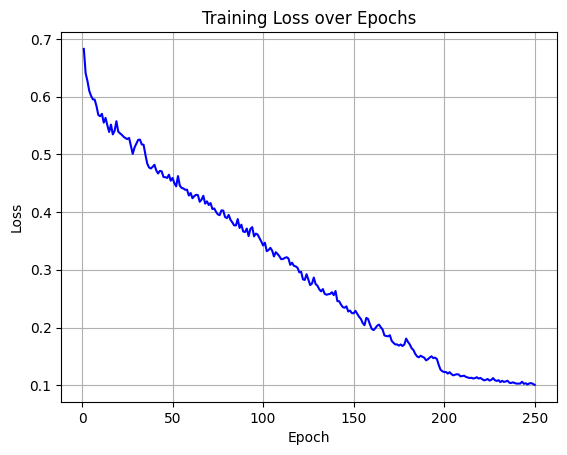

In [32]:
import matplotlib.pyplot as plt

# Assuming loss_history is a list of tuples (epoch, loss)
epochs, losses = zip(*loss_history)

# Create a line plot
plt.plot(epochs, losses, marker='', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [33]:
plt.savefig('training_loss_plot.png')


<Figure size 640x480 with 0 Axes>

## Image Augmentation

In [34]:
# Define custom transformations for satellite images
satellite_image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# Define custom transformations for binary masks
binary_mask_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
])

In [35]:

def create_augmented_dataset():

    # Creates directories
    for dirname in (TRAIN_AUG_IMAGES, TRAIN_AUG_IMAGES_GT):
        os.makedirs(dirname, exist_ok=True)

    # Load the original dataset
    images = sorted(os.listdir(TRAIN_IMAGES))
    masks = sorted(os.listdir(GROUNDTRUTH))

    for i in range(len(images)):
        # Get image and mask names
        image_name = images[i]
        mask_name = masks[i]
        print(image_name)
        print(mask_name)

        # Get images paths
        image_path = os.path.join(TRAIN_IMAGES, image_name)
        mask_path = os.path.join(GROUNDTRUTH, mask_name)

        # Open images
        image = Image.open(image_path)
        mask = Image.open(mask_path)

        #apply the transformations
        image_transformed = satellite_image_transform(image)
        mask_transformed = binary_mask_transform(mask)

        # Convert tensors to PIL Images
        image_transformed_PIL = transforms.ToPILImage()(image_transformed)
        mask_transformed_PIL = transforms.ToPILImage()(mask_transformed)

        # Save augmented dataset
        filename_img = f'Image_{i+1:04d}.png'
        filename_gd = f'gdImage_{i+1:04d}.png'
        image_path_aug = os.path.join(TRAIN_AUG_IMAGES, filename_img)
        mask_path_aug = os.path.join(TRAIN_AUG_IMAGES_GT, filename_gd)
        new_image_path= os.path.join(TRAIN_AUG_IMAGES, image_name)
        new_mask_path=os.path.join(TRAIN_AUG_IMAGES_GT, mask_name)
        image.save(new_image_path)
        mask.save(new_mask_path)
        image_transformed_PIL.save(image_path_aug)
        mask_transformed_PIL.save(mask_path_aug)
        image.save




In [36]:
#create augmented dataset
create_augmented_dataset()

satImage_001.png
satImage_001.png
satImage_002.png
satImage_002.png
satImage_003.png
satImage_003.png
satImage_004.png
satImage_004.png
satImage_005.png
satImage_005.png
satImage_006.png
satImage_006.png
satImage_007.png
satImage_007.png
satImage_008.png
satImage_008.png
satImage_009.png
satImage_009.png
satImage_010.png
satImage_010.png
satImage_011.png
satImage_011.png
satImage_012.png
satImage_012.png
satImage_013.png
satImage_013.png
satImage_014.png
satImage_014.png
satImage_015.png
satImage_015.png
satImage_016.png
satImage_016.png
satImage_017.png
satImage_017.png
satImage_018.png
satImage_018.png
satImage_019.png
satImage_019.png


KeyboardInterrupt: ignored

## Testing and submission

In [38]:
test_image_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [39]:
test_set = ImagesDataset(
    img_dir=TEST_IMAGES,
    image_transform=test_image_transform,
)

In [40]:
test_loader = DataLoader(
    dataset=test_set,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

In [37]:
def _get_pred_filename(lenth_loader, index: int) -> str:
    """Returns the filename of the prediction.

    Args:
        index (int): index of the image in the dataset.

    Returns:
        str: filename of the prediction.
    """
    if lenth_loader > 1000:
        return f'prediction_{index + 1:04d}.png'
    return f'prediction_{index + 1:03d}.png'

In [41]:
def _predict_labels(
    output: torch.Tensor,
    proba_threshold: float,
) -> torch.Tensor:
    """Predicts the labels for an output.

    Args:
        output (torch.Tensor): tensor output.
        proba_threshold (float): probability threshold.

    Returns:
        torch.Tensor: tensor of 0 and 1.
    """
    return (output > proba_threshold).type(torch.uint8)

In [42]:
def _save_mask(
    output: torch.Tensor,
    filename: str,
) -> None:
    """Saves the mask as image.

    Args:
        output (torch.Tensor): tensor output.
        filename (str): filename.
        clean (bool, optional): True to clean the prediction using
        postprocessing method. Defaults to True.
    """
    pred_array = torch.squeeze(output * 255).cpu().numpy()
    img = Image.fromarray(pred_array)
    img.save(filename)

In [43]:
predictions_path= 'predictions/'

In [44]:
prediction_filnames = list()

In [ ]:
#Run this only if you load the model
model= UNet().to(device)
state_dict = torch.load('models/trained_model_100ep_10batch.pth', map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [45]:
os.makedirs(predictions_path, exist_ok=True)

In [46]:
# Set the model in evaluation mode
model.eval()

# Switch off autograd
with torch.no_grad():
    # Loop over the dataset
    for i, (data, target) in enumerate(test_loader):
        filename = _get_pred_filename(len(test_loader),i)
        print(f'Processing {filename}')

        # Send the input to the device
        data = data.to(device)
        if target.dim() != 1:
            target = target.to(device)

        # Make the predictions
        output = model(data)

        # Get labels
        output = _predict_labels(output, 0.25)

        # Save mask
        output_path = os.path.join(predictions_path, filename)
        _save_mask(output, output_path)
        prediction_filnames.append(output_path)

# Print a message after processing all images
print('Prediction completed.')


Processing prediction_001.png
Processing prediction_002.png
Processing prediction_003.png
Processing prediction_004.png
Processing prediction_005.png
Processing prediction_006.png
Processing prediction_007.png
Processing prediction_008.png
Processing prediction_009.png
Processing prediction_010.png
Processing prediction_011.png
Processing prediction_012.png
Processing prediction_013.png
Processing prediction_014.png
Processing prediction_015.png
Processing prediction_016.png
Processing prediction_017.png
Processing prediction_018.png
Processing prediction_019.png
Processing prediction_020.png
Processing prediction_021.png
Processing prediction_022.png
Processing prediction_023.png
Processing prediction_024.png
Processing prediction_025.png
Processing prediction_026.png
Processing prediction_027.png
Processing prediction_028.png
Processing prediction_029.png
Processing prediction_030.png
Processing prediction_031.png
Processing prediction_032.png
Processing prediction_033.png
Processing

In [47]:
from helper import *
masks_to_submission('submission2.csv', *prediction_filnames)